In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            602 non-null    object 
 1   Player          602 non-null    object 
 2   MatchId         602 non-null    object 
 3   Map             602 non-null    object 
 4   Category        602 non-null    object 
 5   Playlist        602 non-null    object 
 6   Input           602 non-null    object 
 7   Queue           602 non-null    object 
 8   Csr             602 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         602 non-null    object 
 11  Accuracy        602 non-null    float64
 12  DamageDone      602 non-null    int64  
 13  DamageTaken     602 non-null    int64  
 14  ShotsFired      602 non-null    int64  
 15  ShotsLanded     602 non-null    int64  
 16  ShotsMissed     602 non-null    int64  
 17  KD              602 non-null    flo

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - (df['ExpectedKills'] / df['ExpectedDeaths'])

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'Csr', 'ShotsFired', 
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides',
                'Perfects', 'Medals',
                'LengthSeconds'],axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 140 to 601
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Map             386 non-null    object 
 1   Outcome         386 non-null    int64  
 2   Accuracy        386 non-null    float64
 3   DamageDone      386 non-null    int64  
 4   DamageTaken     386 non-null    int64  
 5   KD              386 non-null    float64
 6   KDA             386 non-null    float64
 7   Kills           386 non-null    int64  
 8   Deaths          386 non-null    int64  
 9   Assists         386 non-null    int64  
 10  ExpectedKills   386 non-null    float64
 11  ExpectedDeaths  386 non-null    float64
 12  Score           386 non-null    int64  
 13  LengthMinutes   386 non-null    float64
 14  DamageRatio     386 non-null    float64
 15  Damage/Kill     386 non-null    float64
 16  Kills/10Min     386 non-null    float64
 17  Deaths/10Min    386 non-null    f

In [4]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [5]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.466165
DmgT/10Min        0.375943
KD                0.330078
Deaths            0.326348
ExcessDeaths      0.287429
DamageRatio       0.276381
KDA               0.273419
DamageTaken       0.239791
ExcessKD          0.230502
ExpectedDeaths    0.203366
Assists/10Min     0.191707
Damage/Kill       0.163663
LengthMinutes     0.122050
Kills/10Min       0.108158
DamageDone        0.095749
Accuracy          0.078225
Assists           0.059288
ExcessKills       0.038147
Kills             0.032443
Score             0.031857
Shots/10Min       0.021505
ExpectedKills     0.012155
Dmg/10Min         0.006380
Name: Outcome, dtype: float64


In [6]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [7]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,386.0,0.531088,0.499680,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,386.0,51.902254,5.225567,36.800000,48.612500,52.060000,54.797500,80.560000
DamageDone,386.0,5114.318653,1804.207328,667.000000,3798.500000,4784.000000,6315.750000,12673.000000
DamageTaken,386.0,4423.443005,1530.035717,875.000000,3410.250000,4161.500000,5349.250000,9962.000000
KD,386.0,1.239197,0.667323,0.290000,0.850000,1.120000,1.430000,6.000000
KDA,386.0,4.294301,5.610659,-9.660000,0.660000,4.000000,7.660000,31.000000
Kills,386.0,14.398964,6.374983,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,386.0,12.854922,5.085216,1.000000,9.000000,12.000000,16.000000,30.000000
Assists,386.0,8.256477,4.157799,1.000000,6.000000,8.000000,10.000000,27.000000
ExpectedKills,386.0,14.313472,4.388613,3.000000,11.000000,13.000000,17.000000,28.000000


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (386, 24)
Y Shape: (386,)


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (308, 24)
X Test Shape: (78, 24)


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['KD', 'KDA', 'Kills', 'Deaths', 'Assists', 'DamageDone', 'DamageTaken', 'DamageRatio', 
                                   'Damage/Kill', 'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min', 'DmgT/10Min',
                                   'ExcessKills', 'ExcessDeaths', 'ExcessKD', 'ExpectedKills', 'ExpectedDeaths', 'Score', 'Shots/10Min']),
        ('cat', OneHotEncoder(), ['Map'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:20], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Logistic Regression

In [13]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))

Unregularized Logistic Regression Accuracy: 0.7692307692307693
Acc: 0.769
MAE: 0.23
MSE: 0.23
RMSE: 0.48
R^2 Score: 0.07
OOS R^2 Score: 0.09



## Ridge

In [14]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
ridge_cv.cv_results_
paramResults(ridge_cv)

LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.8205128205128205
   C_param  Accuracy
0    0.001  0.636489
1    0.010  0.711317
2    0.100  0.766631
3    1.000  0.808620
4   10.000  0.828080
5  100.000  0.824855


''

In [15]:
ResultsOut(ridge_cv)

Acc: 0.821
MAE: 0.18
MSE: 0.18
RMSE: 0.42
R^2 Score: 0.28
OOS R^2 Score: 0.29


''

## Lasso

In [16]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
lasso_cv.cv_results_
paramResults(lasso_cv)


LogisticRegression(C=10, penalty='l1', solver='saga')
Lasso Accuracy: 0.8205128205128205
   C_param  Accuracy
0    0.001  0.545426
1    0.010  0.545426
2    0.100  0.704759
3    1.000  0.815124
4   10.000  0.824855
5  100.000  0.824855


''

In [17]:
ResultsOut(lasso_cv)

Acc: 0.821
MAE: 0.18
MSE: 0.18
RMSE: 0.42
R^2 Score: 0.28
OOS R^2 Score: 0.29


''

## ElasticNet

In [18]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
elastic_cv.cv_results_
paramResults(elastic_cv)

LogisticRegression(C=10, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8205128205128205
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.545426
1     0.001            0.50  0.545426
2     0.001            0.75  0.545426
3     0.010            0.25  0.668905
4     0.010            0.50  0.545426
5     0.010            0.75  0.545426
6     0.100            0.25  0.753622
7     0.100            0.50  0.727499
8     0.100            0.75  0.733950
9     1.000            0.25  0.808620
10    1.000            0.50  0.818297
11    1.000            0.75  0.821576
12   10.000            0.25  0.828080
13   10.000            0.50  0.828080
14   10.000            0.75  0.824855
15  100.000            0.25  0.824855
16  100.000            0.50  0.824855
17  100.000            0.75  0.824855


''

In [19]:
ResultsOut(elastic_cv)

Acc: 0.821
MAE: 0.18
MSE: 0.18
RMSE: 0.42
R^2 Score: 0.28
OOS R^2 Score: 0.29


''

## K-Nearest Neighbours

In [20]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
paramResults(knn_cv)

KNeighborsClassifier(n_neighbors=19)
K-Nearest Neighbors Accuracy: 0.7051282051282052
    n_neighbors_param  Accuracy
0                   1  0.626917
1                   4  0.646219
2                   7  0.655896
3                  10  0.659334
4                  13  0.698202
5                  16  0.717768
6                  19  0.720941
7                  22  0.701481
8                  25  0.698308
9                  28  0.701534
10                 31  0.714595
11                 34  0.701639
12                 37  0.704759
13                 40  0.688630
14                 43  0.685352
15                 46  0.685299
16                 49  0.701534


''

In [21]:
ResultsOut(knn_cv)

Acc: 0.705
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.18
OOS R^2 Score: -0.16


''

## Random Forest

In [22]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=20, random_state=69)
Random Forest Accuracy: 0.782051282051282
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.717715
1               10                 300  0.717610
2               10                 500  0.714384
3               15                 100  0.727340
4               15                 300  0.730672
5               15                 500  0.720941
6               20                 100  0.733792
7               20                 300  0.730672
8               20                 500  0.717663


''

In [23]:
ResultsOut(rf_cv)

Acc: 0.782
MAE: 0.22
MSE: 0.22
RMSE: 0.47
R^2 Score: 0.13
OOS R^2 Score: 0.14


''

<AxesSubplot: >

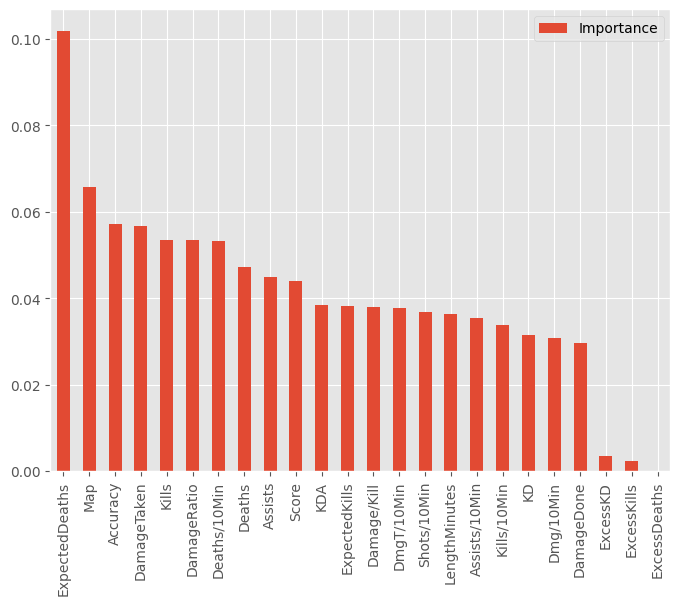

In [24]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [25]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=2, n_estimators=500, random_state=69,
                           subsample=1)
Gradient Boosed Trees Accuracy: 0.7692307692307693
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              1.0   
2                  0.01                2                 300              0.5   
3                  0.01                2                 300              1.0   
4                  0.01                2                 500              0.5   
5                  0.01                2                 500              1.0   
6                  0.01                4                 100              0.5   
7                  0.01                4                 100              1.0   
8                  0.01                4                 300              0.5   
9                  0.01 

''

In [26]:
ResultsOut(GBRT)

Acc: 0.769
MAE: 0.23
MSE: 0.23
RMSE: 0.48
R^2 Score: 0.07
OOS R^2 Score: 0.09


''

<AxesSubplot: >

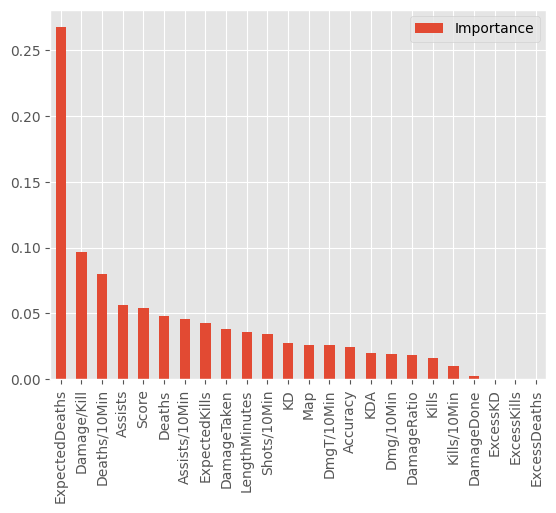

In [27]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [28]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=475, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7564102564102564
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.711264
1                 0.001                1                 450  0.711264
2  

''

In [29]:
ResultsOut(XGB)

Acc: 0.756
MAE: 0.24
MSE: 0.24
RMSE: 0.49
R^2 Score: 0.02
OOS R^2 Score: 0.04


''

<AxesSubplot: >

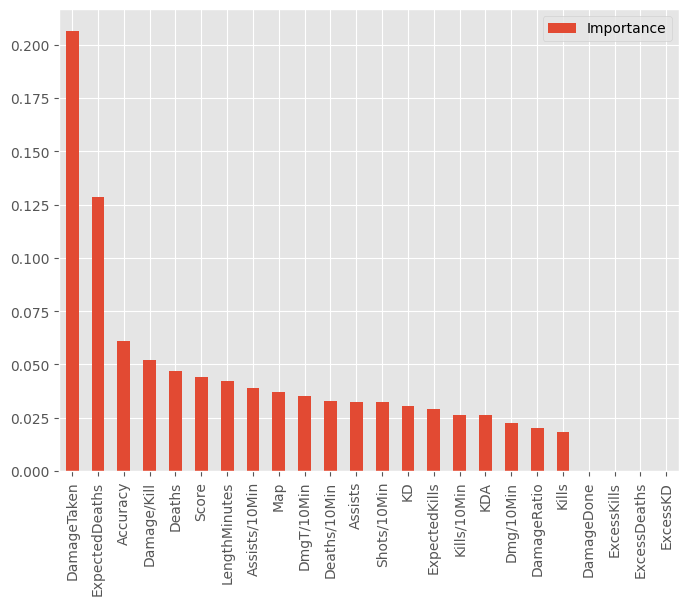

In [30]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

Runtime: 27.96s


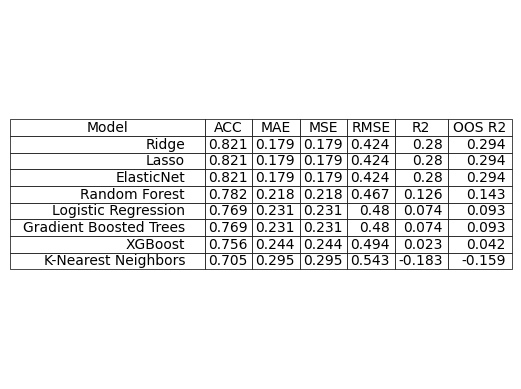

In [31]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0110.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)
print(f'Runtime: {round(time.perf_counter() - start,2)}s')